In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

Force extraction script (based on integration script)

In [2]:
def extract_force(dirs, start=35000, end=75000, size=2000, force_plot=False):
    '''
    Calculates the forces for a simulated system. Requirements:
    - folders in which the results are located must be called the same as the CV value at the umbrella, e.g. 2.1: that defines the umbrellas; these folders must contain COLVAR files from PLUMED
    - time resolutino in COLVAR file must be 1 ps for indexing
    '''
    
    # define the bins / blocks from input parameters, as well as the umbrella centers
    bins = np.arange(start, end, size)
    umbrellas = [float(u) for u in dirs]

    # initialise numpy arrays that will store n rows of m averaged binned forces (n=number of blocks; m=number of umbrellas to integrate)
    # each row will be an input for integration to get a separate free energy profile
    # std_err is the standard deviation of obtained free energy paths, it will contain n elements
    n_bins = len(bins)-1
    n_umbrellas = len(umbrellas)
    binned_forces = np.zeros(shape=(n_bins, n_umbrellas))
   
    # this is for staying in the same folder at the end
    this_dir = os.getcwd()

    # open each COLVAR file in the umbrella folder
    # nd will be used for indexing when replacing 0s with actual binned forces in the numpy array
    for nd, d in enumerate(dirs):
        os.chdir(d)
        print(f"Folder: {d}")

        # extract info about relevant parameters from COLVAR
        with open('COLVAR') as f:
            lines = f.readlines()[1:]

            # initialise the list storing forces from COLVAR
            force_raw = []

            # define the centre of the umbrella and the force constant from the last recorded value
            ref = float(lines[-1].strip().split()[4])
            kappa = float(lines[-1].strip().split()[6])

            # get the remaining params
            for l in lines:
                params = l.strip().split()

                # calculate the force as -k(com-com_ref)
                com_raw = float(params[1])
                force_raw.append(-kappa*(com_raw - ref))
                
            # calculate the average force per bin
            for i in range(n_bins):
                bin_start, bin_end = bins[i], bins[i+1]
                f_bin = np.mean(force_raw[bin_start:bin_end])

                # replace the zeros in the force matrix with the averaged values
                binned_forces[i][nd] = f_bin
        
        os.chdir('../')
        print("Changing directory...")

    # change back to the main directory
    os.chdir(this_dir)

    # averaged free energy profile
    final_force = np.average(binned_forces, axis=0)
    std_dev = np.std(binned_forces, axis=0)

    if force_plot:
        # plot the results, normal
        pl, ax = plt.subplots(figsize=(12,12))
        ax.plot(umbrellas, final_force)
        ax.plot(umbrellas, final_force+std_dev)
        ax.plot(umbrellas, final_force-std_dev)
        ax.set_title('Forces (avg)')
        ax.set_xlabel('COM separation / nm')
        ax.set_ylabel('Force / kcal/mol')
        pl.show()
        pl.savefig('forceplot.png')

    print(binned_forces.shape)

    return final_force, std_dev


In [15]:
results_for_bayes = []

Folder: 1.6
Changing directory...
Folder: 2.1
Changing directory...
Folder: 2.6
Changing directory...
Folder: 3.1
Changing directory...
Folder: 3.6
Changing directory...
Folder: 4.1
Changing directory...
Folder: 4.6
Changing directory...
Folder: 5.1
Changing directory...
Folder: 5.6
Changing directory...
Folder: 6.1
Changing directory...
Folder: 6.6
Changing directory...
(19, 11)


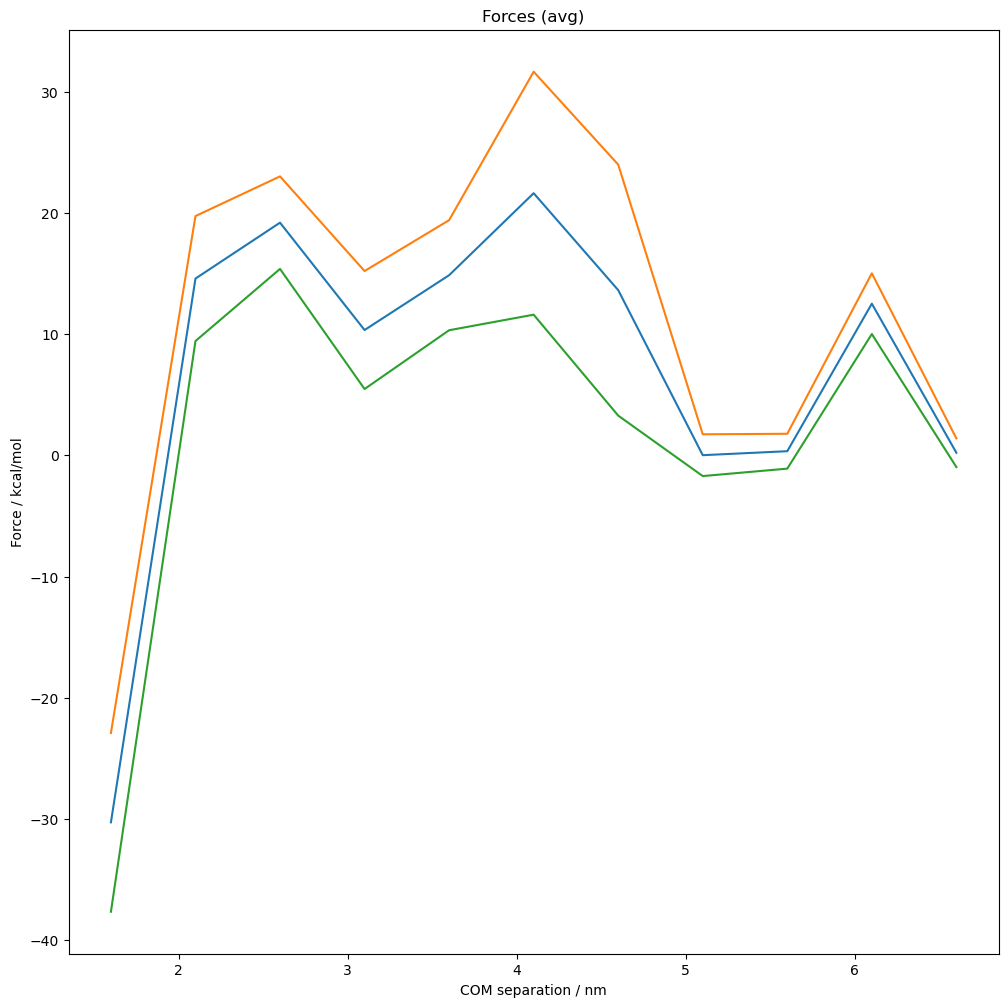

In [16]:
os.chdir('/home/fkopczynski/results/Ca/plumed/umbrella')
dirs = sorted([x for x in os.listdir() if os.path.isdir(x)])
f, std = extract_force(dirs=dirs, force_plot=True)
results_for_bayes.append(list(f))

Folder: 1.6
Changing directory...
Folder: 2.1
Changing directory...
Folder: 2.6
Changing directory...
Folder: 3.1
Changing directory...
Folder: 3.6
Changing directory...
Folder: 4.1
Changing directory...
Folder: 4.6
Changing directory...
Folder: 5.1
Changing directory...
Folder: 5.6
Changing directory...
Folder: 6.1
Changing directory...
Folder: 6.6
Changing directory...
(19, 11)


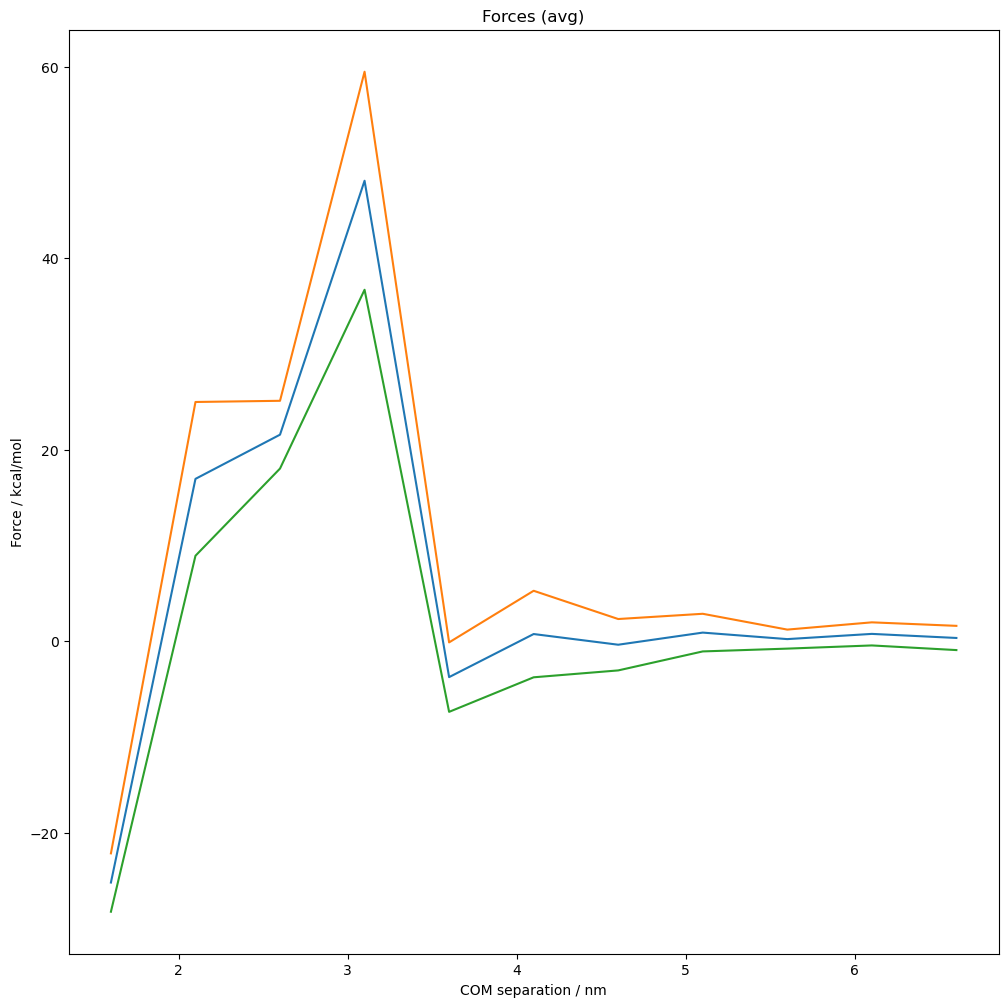

In [17]:
os.chdir('/home/fkopczynski/results/plastic/ps/ps10/prot_pl/plumed/')
dirs = sorted([x for x in os.listdir() if os.path.isdir(x)])
f, std = extract_force(dirs=dirs, force_plot=True)
results_for_bayes.append(list(f))

Folder: 1.6


Changing directory...
Folder: 2.1
Changing directory...
Folder: 2.6
Changing directory...
Folder: 3.1
Changing directory...
Folder: 3.6
Changing directory...
Folder: 4.1
Changing directory...
Folder: 4.6
Changing directory...
Folder: 5.1
Changing directory...
Folder: 5.6
Changing directory...
Folder: 6.1
Changing directory...
Folder: 6.6
Changing directory...
(19, 11)


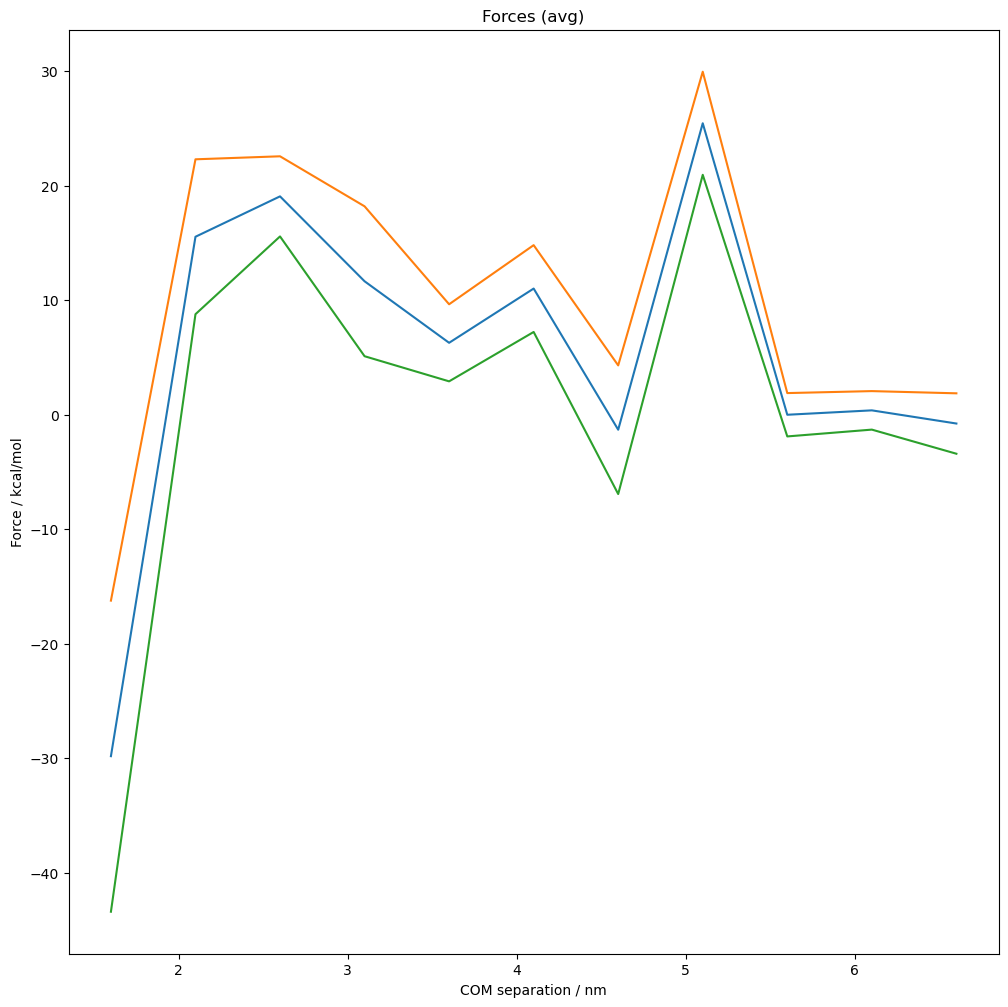

In [18]:
os.chdir('/home/fkopczynski/results/plastic_protein/plumed/umbrella')
dirs = sorted([x for x in os.listdir() if os.path.isdir(x)])
f, std = extract_force(dirs=dirs, force_plot=True)
results_for_bayes.append(list(f))

In [19]:
print(results_for_bayes)

[[-30.268820789473633, 14.579715052631622, 19.190460644736888, 10.33424946052636, 14.856456881578996, 21.62012953947351, 13.628588289473507, 0.012775631578769259, 0.3406779078945591, 12.508910973684033, 0.21452071052613803], [-25.188872381578904, 16.960575907894782, 21.57553236842109, 48.089532302631625, -3.7394148421052193, 0.7589639605261377, -0.356555881579125, 0.9089245263156126, 0.22910882894719065, 0.7744599078945595, 0.34886796052613767], [-29.811372671052588, 15.544790342105308, 19.071600368421098, 11.658016315789519, 6.284280171052677, 11.020756381578769, -1.3047369078949158, 25.45458977631561, 0.0019442236840332768, 0.3854878947366644, -0.7639657763159674]]


In [29]:
results_for_bayes = np.array(results_for_bayes)
results_for_bayes_1D = results_for_bayes.flatten()
print(results_for_bayes_1D)
print(list(results_for_bayes_1D))

[-3.02688208e+01  1.45797151e+01  1.91904606e+01  1.03342495e+01
  1.48564569e+01  2.16201295e+01  1.36285883e+01  1.27756316e-02
  3.40677908e-01  1.25089110e+01  2.14520711e-01 -2.51888724e+01
  1.69605759e+01  2.15755324e+01  4.80895323e+01 -3.73941484e+00
  7.58963961e-01 -3.56555882e-01  9.08924526e-01  2.29108829e-01
  7.74459908e-01  3.48867961e-01 -2.98113727e+01  1.55447903e+01
  1.90716004e+01  1.16580163e+01  6.28428017e+00  1.10207564e+01
 -1.30473691e+00  2.54545898e+01  1.94422368e-03  3.85487895e-01
 -7.63965776e-01]
[-30.268820789473633, 14.579715052631622, 19.190460644736888, 10.33424946052636, 14.856456881578996, 21.62012953947351, 13.628588289473507, 0.012775631578769259, 0.3406779078945591, 12.508910973684033, 0.21452071052613803, -25.188872381578904, 16.960575907894782, 21.57553236842109, 48.089532302631625, -3.7394148421052193, 0.7589639605261377, -0.356555881579125, 0.9089245263156126, 0.22910882894719065, 0.7744599078945595, 0.34886796052613767, -29.811372671052